In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1
import random
import datetime
import time

degree_sign = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})
mp.rcParams['hatch.color'] = '0.5'

% matplotlib inline

# Set up lat/lon of locations of interest

In [2]:
LA_lat = 34.0522
LA_lon = 118.2437 # deg west
LA_lon = 180. + (180-LA_lon)

Oroville_dam_lat = 39.5380
Oroville_dam_lon = 121.4831 # deg west
Oroville_dam_lon = 360 - Oroville_dam_lon

SF_lat = 37.7749
SF_lon = 122.4194
SF_lon = 360 - SF_lon

# Import coastal grid point indices

In [3]:
cali_coast_latlon_indices = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/coastal_latlon_array_indices_3x.npy')
cali_coast_latlon_indices_zip = [i for i in zip(cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1])]

cali_coast_latlon_indices_3d = cali_coast_latlon_indices.reshape((11,3,2))
#print(cali_coast_latlon_indices_3d[0,:,:])

# Specify return period information and percentiles

In [4]:
#return_period = 200 # in years
#events_per_year = 151-40

return_period = 200
events_per_year = 151/40

return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

99.86754966887416


# Set up directories where data are stored

In [5]:
working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'
#save_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calculations/npy_files/'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [6]:
working_dir = '/Users/baird/google_drive/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/'
#threshold=0.0
threshold=0.1
#threshold=0.5
#threshold=1.0
#threshold=5.0
#threshold=10.0

# Import lat/lon information

In [7]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

days_per_season = 30+31+31+28+31

# Open PIC data

In [8]:
year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

# create season strings
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
#half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)
#season_strings_pic = numpy.empty(years.size-1, dtype=numpy.str)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_pic=year_end_pic-year_start_pic

# Save all events as a numpy array, and save return period values

# Open all PIC events (which have already been saved as a npy array)

In [9]:
all_events_pic = numpy.load('csv_files/all_events_pic.npy')

In [10]:
print(all_events_pic.shape) # note the very last season is missing one day

(650, 271497)


# Open return period calculations

In [11]:
return_period_values_pic_df = pandas.read_csv('csv_files/return_period_values_pic_df_update.csv')
return_period_values_pic = return_period_values_pic_df.values[:,1:]

# Open historical, RCP and place all data into a 3d array

In [12]:
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

In [13]:
year_start = 1920
year_end = 2100

year_start_list = numpy.arange(1920,2100)
year_end_list = numpy.arange(1921,2101)
year_middle_list = year_start_list+1

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)
season_strings_hist_rcp = [str(i)+'-'+str(i+1) for i in range(year_start,year_end)]

thirty_yr_strings_hist_rcp = [str(year_start_list[i])+'-'+str(year_end_list[i]) for i in range(year_start_list.size)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

## Open all data already saved in npy array

In [14]:
all_events_hist_rcp_3d = numpy.load('csv_files/all_events_hist_rcp_3d.npy')
print(all_events_hist_rcp_3d.shape)

(650, 40, 27180)


## Calculate all return periods for all time (1 year at a time)

In [15]:
print(n_seasons_hist_rcp)

180


In [16]:
#nlat_unique = numpy.unique(cali_coast_latlon_indices[:,0]).size
return_period_values_hist_rcp = numpy.zeros((len(latlon_indices), n_seasons_hist_rcp, 3))
#print(latitude_time_values.shape)

window=1

for yr_idx in range(n_seasons_hist_rcp):
    season_strings_hist_rcp = [str(i)+'-'+str(i+1) for i in range(year_start,year_end)]
    
    for latlon_idx in range(len(latlon_indices)):

        seasonal_events = all_events_hist_rcp_3d[latlon_idx,:,(yr_idx*days_per_season):(yr_idx+1)*days_per_season].reshape((-1))

        return_period_values_hist_rcp[latlon_idx,yr_idx,0] = numpy.nanpercentile(seasonal_events, return_val_perc)
        return_period_values_hist_rcp[latlon_idx,yr_idx,1] = numpy.nansum(seasonal_events>return_period_values_hist_rcp[latlon_idx,yr_idx,0])
        return_period_values_hist_rcp[latlon_idx,yr_idx,2] = numpy.nansum(seasonal_events>return_period_values_pic[latlon_idx,0])
    #return_period_values_hist_rcp_df = pandas.DataFrame(return_period_values_hist_rcp, columns=['Perc value hist eoc','Num hist eoc exceedances','Num PIC exceedances'])


/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


# Doing AD k-sample test on >= median values

# Import max values

## Calculate PIC max values

## Calculate hist+RCP8.5 max values

# Using R library to calculate AD k-sample test

# Test AD k-sample test limits

In [17]:
sig_test_values = numpy.load('csv_files/sig_test_values_no_smoothing_ks_2samp.npy')

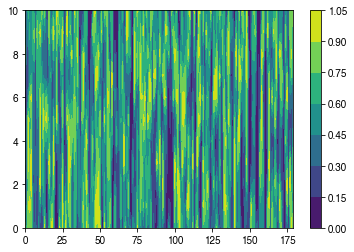

In [42]:
#cf=mp.contourf(sig_test_values, levels=[0,0.1,0.5,1], extend='max')
cf=mp.contourf(sig_test_values)#, extend='max')
mp.colorbar(cf)

# ALSO calculating average return period values for 3 lon/lat grid points approaching California coast

In [19]:
# calculate ratio of frequencies of exceedance
pic_counts = return_period_values_pic[:,1]
hist_rcp_counts = return_period_values_hist_rcp[:,:,2]

#return_values_pic_2d = return_period_values_pic[:,0].reshape(PRECT_nlat, PRECT_nlon)
#return_values_hist_rcp_2d = return_period_values_hist_rcp[:,0].reshape(PRECT_nlat, PRECT_nlon)

print(pic_counts.shape, hist_rcp_counts.shape)
count_ratio = ((hist_rcp_counts/(40)).T/(pic_counts/1798)).T
count_ratio_2d = count_ratio.reshape((PRECT_nlat, PRECT_nlon, -1))
count_ratio_2d_cali = numpy.mean( count_ratio_2d[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1],:].reshape((11,3,-1)) , axis=1)

return_period_values_hist_rcp_4d = return_period_values_hist_rcp.reshape((PRECT_nlat,PRECT_nlon,-1,3))
return_period_values_hist_rcp_cali_coast = return_period_values_hist_rcp_4d[cali_coast_latlon_indices[:,0], \
                                                                           cali_coast_latlon_indices[:,1], \
                                                                           :,:]

return_period_values_hist_rcp_cali_coast = numpy.mean(return_period_values_hist_rcp_cali_coast.reshape((11,3,-1,3)), axis=1)
print(return_period_values_hist_rcp_cali_coast.shape)

(650,) (650, 180)
(11, 180, 3)


In [20]:
#hist_rcp_counts_cali_coast = numpy.mean(hist_rcp_counts[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1],:])
hist_rcp_counts_2d = numpy.reshape(hist_rcp_counts, (PRECT_nlat, PRECT_nlon, -1))
hist_rcp_counts_2d_cali_coast = hist_rcp_counts_2d[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1],:]
hist_rcp_counts_2d_cali_coast = numpy.mean( hist_rcp_counts_2d_cali_coast.reshape((11,3,-2)), axis=1)

# Do same calculation for PIC runs

In [21]:
return_period_values_pic_4d = return_period_values_pic[:,0].reshape((PRECT_nlat,PRECT_nlon))
return_period_values_pic_cali_coast = return_period_values_pic_4d[cali_coast_latlon_indices[:,0], \
                                                                           cali_coast_latlon_indices[:,1]]

return_period_values_pic_cali_coast = numpy.mean(return_period_values_pic_cali_coast.reshape((11,3,-1)), axis=1)

# Now plot for hist+RCP8.5

In [22]:
print(return_period_values_hist_rcp_cali_coast[:,:,0].shape)

(11, 180)


In [23]:
window = 30
values_2d_cali_smoothed = numpy.zeros((return_period_values_hist_rcp_cali_coast[:,:,0].shape))
for row_idx in range(values_2d_cali_smoothed.shape[0]):
    values_2d_cali_smoothed[row_idx,:] = pandas.Series(return_period_values_hist_rcp_cali_coast[:,:,0][row_idx,:]).rolling(window=window, center=True).mean()

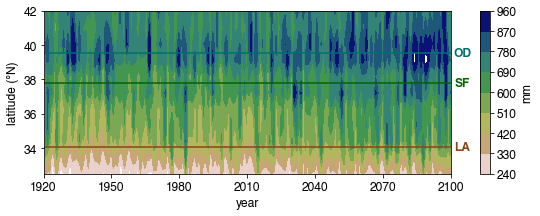

In [24]:
fontsize=12

fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)

contour_levels = numpy.arange(240,961,90)
ax_cf = ax.contourf(half_years_hist_rcp, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    return_period_values_hist_rcp_cali_coast[:,:,0], \
                    #values_2d_cali_smoothed, \
                    levels=contour_levels, \
                    cmap='gist_earth_r')
#ax.set_xticks()

la_color = 'saddlebrown'
sf_color = 'darkgreen'
od_color = '#007070' # '#008080' is teal

#ax.axhline(LA_lat, c='firebrick', zorder=1)
ax.axhline(LA_lat, c=la_color, zorder=1)
ax.axhline(SF_lat, c=sf_color, zorder=1)
ax.axhline(Oroville_dam_lat, c=od_color, zorder=1)

ax.text(s='LA', x=2105, y=LA_lat, color=la_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='SF', x=2105, y=SF_lat, color=sf_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='OD', x=2105, y=Oroville_dam_lat, color=od_color, ha='center', va='center', fontsize=fontsize, weight='bold')

ax.set_xlim(1920,2100)
ax.set_xticks(numpy.arange(1920,2101,30))
ax.set_yticks(numpy.arange(34,43,2))

ax.tick_params(labelsize=fontsize)

ax.set_ylabel('latitude ('+degree_sign+'N)', fontsize=fontsize)
ax.set_xlabel('year', fontsize=fontsize)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('right', size='2.5%', pad=0.4) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(ax_cf, cax=cbar_ax, orientation='vertical')
cbar.set_label('mm', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# Calculating changes in frequency of occurrence

# ALSO calculating return period values

In [25]:
# calculate ratio of frequencies of exceedance
pic_counts = return_period_values_pic[:,1]
hist_rcp_counts = return_period_values_hist_rcp[:,:,2]

#return_values_pic_2d = return_period_values_pic[:,0].reshape(PRECT_nlat, PRECT_nlon)
#return_values_hist_rcp_2d = return_period_values_hist_rcp[:,0].reshape(PRECT_nlat, PRECT_nlon)

print(pic_counts.shape, hist_rcp_counts.shape)
count_ratio = ((hist_rcp_counts/(40)).T/(pic_counts/1798)).T
count_ratio_2d = count_ratio.reshape((PRECT_nlat, PRECT_nlon, -1))
count_ratio_2d_cali = numpy.mean( count_ratio_2d[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1],:].reshape((11,3,-1)) , axis=1)

hist_rcp_counts_2d = numpy.reshape(hist_rcp_counts, (PRECT_nlat,PRECT_nlon,-1))
pic_counts_2d = numpy.reshape(pic_counts, (PRECT_nlat,PRECT_nlon))

return_period_values_pic_2d = numpy.reshape(return_period_values_pic, (PRECT_nlat, PRECT_nlon,-1))

pic_counts_2d_cali_coast = numpy.mean(pic_counts_2d[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1]].reshape((11,3)), axis=1)                                        
                                                    

(650,) (650, 180)


In [26]:
print(pic_counts_2d_cali_coast)

[ 267.          266.33333333  267.          267.          267.          267.
  267.          267.          267.          267.          267.        ]


In [27]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [28]:
# make color map
minval=0.0 # 
maxval=0.85 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

# Open bootstrap significance values

In [29]:
bootstrap_90th_perc_2d = numpy.load('csv_files/bootstrap_90th_perc_2d.npy')
bootstrap_80th_perc_2d = numpy.load('csv_files/bootstrap_80th_perc_2d.npy')

/Users/baird/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  s)


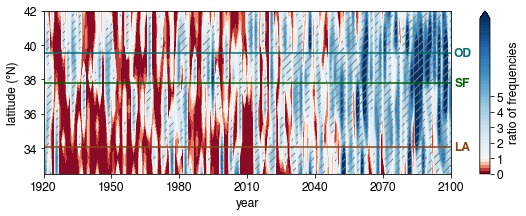

In [30]:
fontsize=12

fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)

contour_levels = numpy.arange(0,10.1,0.2)

ax_cf = ax.contourf(half_years_hist_rcp, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    count_ratio_2d_cali, \
                    norm=MidpointNormalize(midpoint=1.0), \
                    cmap='RdBu', \
                    levels=contour_levels, \
                    extend='max')

# ax_sig = ax.contourf(year_middle_list, \
#                     PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
#                     sig_test_values, \
#                     #count_ratio_2d_cali_bool, \
#                     colors='None', \
#                     levels=[0.0,0.1,1.0], \
#                     #levels=[0.05,1.5], \
#                     hatches=['///',None], \
#                     extend='lower', \
#                     edgecolors='red', \
#                     zorder=2)

gt_booleans_yearly = count_ratio_2d_cali > bootstrap_80th_perc_2d

ax_sig = ax.contourf(year_middle_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    gt_booleans_yearly, \
                    colors='None', \
                    levels=[0.,0.5,1.5], \
                    #levels=[0.05,1.5], \
                    hatches=[None,'///'], \
                    #extend='lower', \
                    edgecolors='red', \
                    zorder=2)

# ax_c = ax.contour(half_years_hist_rcp, \
#                     PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
#                     count_ratio_2d_cali, \
#                     norm=MidpointNormalize(midpoint=1.0), \
#                     levels=[0,0.5,1,1.5,2,3,4,5], \
#                     colors='0.5', \
#                     linestyles=['--']*2+[':']+['-']*5, \
#                     linewidths=[1]*2+[2]+[1]*5, \
#                     zorder=3)

# new_levels = []
# for i in ax_c.levels:
#     if i in [0.5,1.5]:
#         new_levels.append('{:.1f}'.format(i))
#     else:
#         new_levels.append('{:.0f}'.format(i))
# ax_c.levels = new_levels
# mp.clabel(ax_c, fontsize=fontsize, colors='0.25')

la_color = 'saddlebrown'
sf_color = 'darkgreen'
od_color = '#007070' # '#008080' is teal

#ax.axhline(LA_lat, c='firebrick', zorder=1)
ax.axhline(LA_lat, c=la_color, zorder=2)
ax.axhline(SF_lat, c=sf_color, zorder=2)
ax.axhline(Oroville_dam_lat, c=od_color, zorder=2)

ax.text(s='LA', x=2105, y=LA_lat, color=la_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='SF', x=2105, y=SF_lat, color=sf_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='OD', x=2105, y=Oroville_dam_lat, color=od_color, ha='center', va='center', fontsize=fontsize, weight='bold')

ax.set_xlim(1920,2100)
ax.set_xticks(numpy.arange(1920,2101,30))
ax.set_yticks(numpy.arange(34,43,2))

ax.tick_params(labelsize=fontsize)

ax.set_ylabel('latitude ('+degree_sign+'N)', fontsize=fontsize)
ax.set_xlabel('year', fontsize=fontsize)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('right', size='2.5%', pad=0.4)
cbar = fig.colorbar(ax_cf, cax=cbar_ax, orientation='vertical')
cbar.set_label('ratio of frequencies', fontsize=fontsize)#, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks([0,1,2,3,4,5])

fig.savefig('time_latitude_plot_1yr_window.pdf', transparent=True, bbox_inches='tight')

# Now apply 30 year smoothing to above

In [31]:
window = 30
count_ratio_2d_cali_smoothed = numpy.zeros((count_ratio_2d_cali.shape))
for row_idx in range(count_ratio_2d_cali_smoothed.shape[0]):
    count_ratio_2d_cali_smoothed[row_idx,:] = pandas.Series(count_ratio_2d_cali[row_idx,:]).rolling(window=window, center=True).mean()

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/baird/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  s)


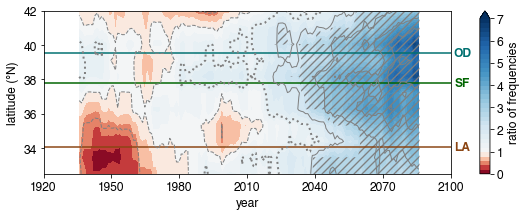

In [32]:
fontsize=12

fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)

contour_levels = numpy.arange(0,7.1,0.2)

ax_cf = ax.contourf(half_years_hist_rcp, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    count_ratio_2d_cali_smoothed, \
                    norm=MidpointNormalize(midpoint=1.0), \
                    cmap='RdBu', \
                    levels=contour_levels, \
                    extend='max')

gt_booleans = numpy.array((count_ratio_2d_cali_smoothed > bootstrap_80th_perc_2d), dtype=bool)

ax_sig = ax.contourf(year_middle_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    gt_booleans, \
                    colors='None', \
                    levels=[0.,0.99,1], \
                    #levels=[0.05,1.5], \
                    hatches=[None,'///'], \
                    #extend='lower', \
                    edgecolors='red', \
                    zorder=2)

ax_sig = ax.contourf(year_middle_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    gt_booleans, \
                    colors='None', \
                    levels=[0.,0.99,1], \
                    #levels=[0.05,1.5], \
                    hatches=[None,'///'], \
                    #extend='lower', \
                    edgecolors='red', \
                    zorder=2)

# ax_sig = ax.contourf(year_middle_list, \
#                     PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
#                     sig_test_values, \
#                     #count_ratio_2d_cali_bool, \
#                     colors='None', \
#                     levels=[0.0,0.01,1.0], \
#                     #levels=[0.05,1.5], \
#                     hatches=['///',None], \
#                     extend='lower', \
#                     edgecolors='red', \
#                     zorder=2)

ax_c = ax.contour(half_years_hist_rcp, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    count_ratio_2d_cali_smoothed, \
                    norm=MidpointNormalize(midpoint=1.0), \
                    levels=[0,0.5,1,1.5,2,3,4,5], \
                    colors='0.5', \
                    linestyles=['--']*2+[':']+['-']*5, \
                    linewidths=[1]*2+[2]+[1]*5, \
                    zorder=3)

# new_levels = []
# for i in ax_c.levels:
#     if i in [0.5,1.5]:
#         new_levels.append('{:.1f}'.format(i))
#     else:
#         new_levels.append('{:.0f}'.format(i))
# ax_c.levels = new_levels
# mp.clabel(ax_c, fontsize=fontsize, colors='0.25')

la_color = 'saddlebrown'
sf_color = 'darkgreen'
od_color = '#007070' # '#008080' is teal

#ax.axhline(LA_lat, c='firebrick', zorder=1)
ax.axhline(LA_lat, c=la_color, zorder=2)
ax.axhline(SF_lat, c=sf_color, zorder=2)
ax.axhline(Oroville_dam_lat, c=od_color, zorder=2)

ax.text(s='LA', x=2105, y=LA_lat, color=la_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='SF', x=2105, y=SF_lat, color=sf_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='OD', x=2105, y=Oroville_dam_lat, color=od_color, ha='center', va='center', fontsize=fontsize, weight='bold')

ax.set_xlim(1920,2100)
ax.set_xticks(numpy.arange(1920,2101,30))
ax.set_yticks(numpy.arange(34,43,2))

ax.tick_params(labelsize=fontsize)

ax.set_ylabel('latitude ('+degree_sign+'N)', fontsize=fontsize)
ax.set_xlabel('year', fontsize=fontsize)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('right', size='2.5%', pad=0.4)
cbar = fig.colorbar(ax_cf, cax=cbar_ax, orientation='vertical')
cbar.set_label('ratio of frequencies', fontsize=fontsize)#, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks([0,1,2,3,4,5,6,7])

fig.savefig('time_latitude_plot_30yr_window.pdf', transparent=True, bbox_inches='tight')

# Save info

In [33]:
PRECT_lat_subset = PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])]

In [34]:
# convert times
time_datetime = [datetime.datetime(i,1,15) for i in year_middle_list]
time_nc = netCDF4.date2num(time_datetime, units='days since 1920-01-01', calendar='standard')

In [35]:
# save hist clim
filename = 'time_latitude_200yr_40d_wet_events_PIC_no_smoothing.nc'

import os; os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat_subset.size)
time_dim = ncfile.createDimension('time', len(year_middle_list))

lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
time_var = ncfile.createVariable('time', 'f4', ('time',))
lat_var[:] = PRECT_lat_subset
time_var[:] = time_nc
lat_var.units = 'degrees_north'
time_var.units = 'days since 1920-01-01'
time_var.description = 'Reported for yearly (seasonal) values; no smoothing or averaging'

ratios_of_frequencies = ncfile.createVariable('time_lat_ratios', 'f4', ('lat','time'))
ratios_of_frequencies[:] = count_ratio_2d_cali
ratios_of_frequencies.units = 'unitless'
ratios_of_frequencies.description = 'Ratio of frequencies for coastal California grid points (average of 3 longitudinal values at each California coastal latitude)'

counts_hist_rcp = ncfile.createVariable('hist_rcp_counts', 'f4', ('lat','time'))
counts_hist_rcp[:] = hist_rcp_counts_2d_cali_coast
counts_hist_rcp.units = 'number of exceedances'
counts_hist_rcp.description = 'Number of exceedances of PIC event (average of 3 longitudinal values at each California coastal latitude)'

counts_pic = ncfile.createVariable('pic_counts', 'f4', ('lat'))
counts_pic[:] = pic_counts_2d_cali_coast
counts_pic.units = 'number of exceedances'
counts_pic.description = 'Number of events in PIC time series (constant value corresponding to appropriate percentile)'

return_period_vals_hist_rcp = ncfile.createVariable('return_period_vals_hist_rcp', 'f4', ('lat','time'))
return_period_vals_hist_rcp[:] = return_period_values_hist_rcp_cali_coast[:,:,0]
return_period_vals_hist_rcp.units = 'mm'
return_period_vals_hist_rcp.description = 'Return period precipitation values for hist+RCP8.5 time series (average of 3 longitudinal grid points at each California coastal latitude)'

return_period_vals_pic = ncfile.createVariable('return_period_vals_pic', 'f4', ('lat',))
return_period_vals_pic[:] = return_period_values_pic_cali_coast[:]
return_period_vals_pic.units = 'mm'
return_period_vals_pic.description = 'Return period precipitation values for PIC time series (average of 3 longitudinal grid points at each California coastal latitude)'

sigtest_threshold = ncfile.createVariable('sigtest_90th_perc', 'f4', ('lat','time'))
sigtest_threshold[:] = bootstrap_90th_perc_2d
sigtest_threshold.description = 'Calculated from bootstrap of N=10,000; any value above this field is signif. at 90% conf. level.'

sigtest_threshold = ncfile.createVariable('sigtest_80th_perc', 'f4', ('lat','time'))
sigtest_threshold[:] = bootstrap_80th_perc_2d
sigtest_threshold.description = 'Calculated from bootstrap of N=10,000; any value above this field is signif. at 80% conf. level.'

ncfile.history = 'Created ' + time.ctime(time.time())
ncfile.close()
print(filename, "saved")

time_latitude_200yr_40d_wet_events_PIC_no_smoothing.nc saved


# Alternative approach using nc files (late Oct 2017)

In [36]:
return_interval = 200
events_per_year = 151/40

return_val_perc = 100*(1-1/(return_interval*events_per_year))
print(return_val_perc)

#print(1798*151/40-return_val_perc/100.*1798*151/40)

99.86754966887416


In [37]:
# calculate ratio of frequencies of exceedance
pic_counts = 10 #return_period_values_pic[:,1]
hist_rcp_counts = numpy.load('../200yr_40d_wet_events/csv_files/event_count.npy')#return_period_values_hist_rcp[:,:,2]

return_period_values_pic = pandas.read_csv('../200yr_40d_wet_events/csv_files/return_period_values_pic_df_update.csv').values[:,1:]

#pic_counts_reshape = pic_counts.reshape((PRECT_nlat, PRECT_nlon))
hist_rcp_counts_ALL_LATLON_reshape = hist_rcp_counts.reshape((PRECT_nlat, PRECT_nlon, 40, 180))

all_events_hist_rcp_3d_reshape = numpy.copy(hist_rcp_counts_ALL_LATLON_reshape)
print(all_events_hist_rcp_3d_reshape.shape)

#hist_rcp_counts_ALL_LATLON_40members = hist_rcp_counts_2d[REGION_lat_idx,REGION_lon_idx,:,:]
hist_rcp_counts_ALL_LATLON_summed_across_40 = numpy.sum(hist_rcp_counts_ALL_LATLON_reshape[:,:,:,:], axis=2)
hist_rcp_counts_ALL_LATLON = numpy.copy(hist_rcp_counts_ALL_LATLON_summed_across_40)

pic_counts_ALL_LATLON = pic_counts*numpy.ones((PRECT_nlat,PRECT_nlon))
#hist_rcp_counts_ALL_LATLON = hist_rcp_counts_reshape[:,:,:]
hist_rcp_counts_ALL_LATLON_smooth = numpy.zeros((hist_rcp_counts_ALL_LATLON.shape))

for i in range(PRECT_nlat):
    for j in range(PRECT_nlon):
        hist_rcp_counts_ALL_LATLON_smooth[i,j] = pandas.Series(hist_rcp_counts_ALL_LATLON[i,j,:]).rolling(window=window, center=True).mean()

pic_counts_ALL_LATLON_equivalent = pic_counts_ALL_LATLON/(1798/40)
hist_rcp_counts_ALL_LATLON_smooth_norm = numpy.zeros((hist_rcp_counts_ALL_LATLON.shape))
for i in range(PRECT_nlat):
    for j in range(PRECT_nlon):
        hist_rcp_counts_ALL_LATLON_smooth_norm[i,j,:] = (hist_rcp_counts_ALL_LATLON_smooth[i,j,:] - pic_counts_ALL_LATLON_equivalent[i,j])/pic_counts_ALL_LATLON_equivalent[i,j] * 100.

hist_rcp_counts_ALL_LATLON_smooth_ratios = numpy.zeros((hist_rcp_counts_ALL_LATLON.shape))
for i in range(PRECT_nlat):
    for j in range(PRECT_nlon):
        hist_rcp_counts_ALL_LATLON_smooth_ratios[i,j,:] = hist_rcp_counts_ALL_LATLON_smooth[i,j,:]/pic_counts_ALL_LATLON_equivalent[i,j]

(26, 25, 40, 180)


In [38]:
print(hist_rcp_counts_ALL_LATLON_smooth_ratios.shape)
hist_rcp_counts_ALL_LATLON_smooth_ratios=hist_rcp_counts_ALL_LATLON_smooth_ratios.transpose(2,0,1)

(26, 25, 180)


In [39]:
count_ratio_2d_cali = numpy.mean( hist_rcp_counts_ALL_LATLON_smooth_ratios[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1],:].reshape((11,3,-1)) , axis=1)

In [40]:
year_list = numpy.arange(1921,2101)

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/baird/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  s)


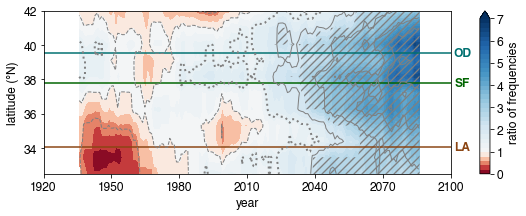

In [41]:
fontsize=12

fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)

contour_levels = numpy.arange(0,7.1,0.2)

ax_cf = ax.contourf(year_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    count_ratio_2d_cali_smoothed, \
                    norm=MidpointNormalize(midpoint=1.0), \
                    cmap='RdBu', \
                    levels=contour_levels, \
                    extend='max')

gt_booleans = numpy.array((count_ratio_2d_cali_smoothed > bootstrap_80th_perc_2d), dtype=bool)

ax_sig = ax.contourf(year_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    gt_booleans, \
                    colors='None', \
                    levels=[0.,0.99,1], \
                    #levels=[0.05,1.5], \
                    hatches=[None,'///'], \
                    #extend='lower', \
                    edgecolors='red', \
                    zorder=2)

ax_sig = ax.contourf(year_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    gt_booleans, \
                    colors='None', \
                    levels=[0.,0.99,1], \
                    #levels=[0.05,1.5], \
                    hatches=[None,'///'], \
                    #extend='lower', \
                    edgecolors='red', \
                    zorder=2)

# ax_sig = ax.contourf(year_middle_list, \
#                     PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
#                     sig_test_values, \
#                     #count_ratio_2d_cali_bool, \
#                     colors='None', \
#                     levels=[0.0,0.01,1.0], \
#                     #levels=[0.05,1.5], \
#                     hatches=['///',None], \
#                     extend='lower', \
#                     edgecolors='red', \
#                     zorder=2)

ax_c = ax.contour(half_years_hist_rcp, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    count_ratio_2d_cali_smoothed, \
                    norm=MidpointNormalize(midpoint=1.0), \
                    levels=[0,0.5,1,1.5,2,3,4,5], \
                    colors='0.5', \
                    linestyles=['--']*2+[':']+['-']*5, \
                    linewidths=[1]*2+[2]+[1]*5, \
                    zorder=3)

# new_levels = []
# for i in ax_c.levels:
#     if i in [0.5,1.5]:
#         new_levels.append('{:.1f}'.format(i))
#     else:
#         new_levels.append('{:.0f}'.format(i))
# ax_c.levels = new_levels
# mp.clabel(ax_c, fontsize=fontsize, colors='0.25')

la_color = 'saddlebrown'
sf_color = 'darkgreen'
od_color = '#007070' # '#008080' is teal

#ax.axhline(LA_lat, c='firebrick', zorder=1)
ax.axhline(LA_lat, c=la_color, zorder=2)
ax.axhline(SF_lat, c=sf_color, zorder=2)
ax.axhline(Oroville_dam_lat, c=od_color, zorder=2)

ax.text(s='LA', x=2105, y=LA_lat, color=la_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='SF', x=2105, y=SF_lat, color=sf_color, ha='center', va='center', fontsize=fontsize, weight='bold')
ax.text(s='OD', x=2105, y=Oroville_dam_lat, color=od_color, ha='center', va='center', fontsize=fontsize, weight='bold')

ax.set_xlim(1920,2100)
ax.set_xticks(numpy.arange(1920,2101,30))
ax.set_yticks(numpy.arange(34,43,2))

ax.tick_params(labelsize=fontsize)

ax.set_ylabel('latitude ('+degree_sign+'N)', fontsize=fontsize)
ax.set_xlabel('year', fontsize=fontsize)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('right', size='2.5%', pad=0.4)
cbar = fig.colorbar(ax_cf, cax=cbar_ax, orientation='vertical')
cbar.set_label('ratio of frequencies', fontsize=fontsize)#, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks([0,1,2,3,4,5,6,7])

fig.savefig('time_latitude_plot_30yr_window.pdf', transparent=True, bbox_inches='tight')